# Optimisation

In [1]:
import pandas as pd
import numpy as np
from scipy.spatial import distance
import matplotlib.pyplot as plt
import time
from scipy.optimize import minimize
import time

In [2]:
lpf_coord = pd.read_csv('saved_pairs/low_pass_filter/coordinates.csv')
# kalman_coord = pd.read_csv('saved_pairs/kalman_filter/coordinates.csv')
nofil_coord = pd.read_csv('saved_pairs/no_filter/coordinates.csv')

In [3]:
# Build the skeleton
skeleton = [['elbow', 'wrist'], ['wrist', 'thumb1'], ['thumb1', 'thumb2'], ['thumb2', 'thumb3'], [
    'wrist', 'index1'], ['index1', 'index2'], ['index2', 'index3'], ['index3', 'index4'], ['wrist',
    'middle1'], ['middle1', 'middle2'], ['middle2', 'middle3'], ['middle3', 'middle4'], ['wrist',
    'ring1'], ['ring1', 'ring2'], ['ring2', 'ring3'], ['ring3', 'ring4'], ['wrist', 'little1'], ['little1',
    'little2'], ['little2', 'little3'], ['little3', 'little4']]

eucl_dst_lpf = {}
eucl_dst_kf = {}
eucl_dst_nofil = {}
for bp1, bp2 in skeleton:
    joint='{}_{}'.format(bp1,bp2)
    eucl_dst_lpf[joint]=[]
    eucl_dst_kf[joint]=[]
    eucl_dst_nofil[joint]=[]
    
# Compute the euclidean distance between joints for each frame
for frame in lpf_coord['frame'].unique():
    frames = lpf_coord[lpf_coord['frame'] == frame]
    for bp1, bp2 in skeleton:
        joint='{}_{}'.format(bp1,bp2)
        data1 = frames[frames['bodypart'] == bp1]
        data2 = frames[frames['bodypart'] == bp2]
        data1_xyz = np.array([data1['x'], data1['y'], data1['z']])
        coord1 = np.hstack(data1_xyz)
        data2_xyz = np.array([data2['x'], data2['y'], data2['z']])
        coord2 = np.hstack(data2_xyz)
        if ~np.isnan(coord1).any() and ~np.isnan(coord2).any():
            eucl_dst_lpf[joint].append(distance.euclidean(coord1, coord2))
        else:
            eucl_dst_lpf[joint].append(np.float64('nan'))
            
# for frame in kalman_coord['frame'].unique():
#     frames = kalman_coord[kalman_coord['frame'] == frame]
#     for bp1, bp2 in skeleton:
#         joint='{}_{}'.format(bp1,bp2)
#         data1 = frames[frames['bodypart'] == bp1]
#         data2 = frames[frames['bodypart'] == bp2]
#         data1_xyz = np.array([data1['x'], data1['y'], data1['z']])
#         coord1 = np.hstack(data1_xyz)
#         data2_xyz = np.array([data2['x'], data2['y'], data2['z']])
#         coord2 = np.hstack(data2_xyz)
#         if ~np.isnan(coord1).any() and ~np.isnan(coord2).any():
#             eucl_dst_kf[joint].append(distance.euclidean(coord1, coord2))
#         else:
#             eucl_dst_kf[joint].append(np.float64('nan'))

for frame in nofil_coord['frame'].unique():
    frames = nofil_coord[nofil_coord['frame'] == frame]
    for bp1, bp2 in skeleton:
        joint='{}_{}'.format(bp1,bp2)
        data1 = frames[frames['bodypart'] == bp1]
        data2 = frames[frames['bodypart'] == bp2]
        data1_xyz = np.array([data1['x'], data1['y'], data1['z']])
        coord1 = np.hstack(data1_xyz)
        data2_xyz = np.array([data2['x'], data2['y'], data2['z']])
        coord2 = np.hstack(data2_xyz)
        if ~np.isnan(coord1).any() and ~np.isnan(coord2).any():
            eucl_dst_nofil[joint].append(distance.euclidean(coord1, coord2))
        else:
            eucl_dst_nofil[joint].append(np.float64('nan'))

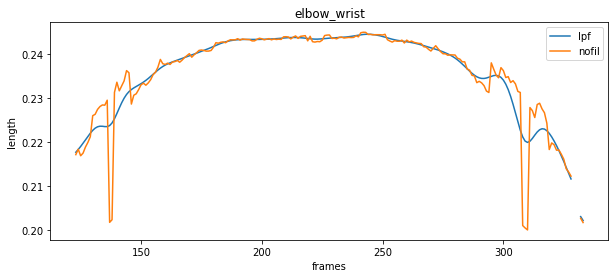

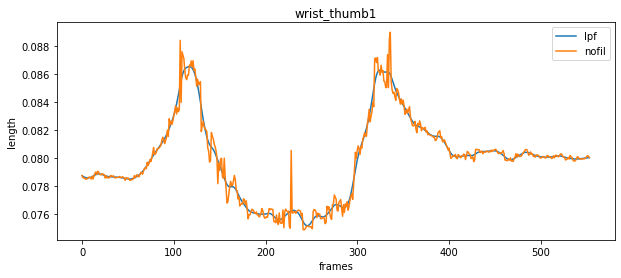

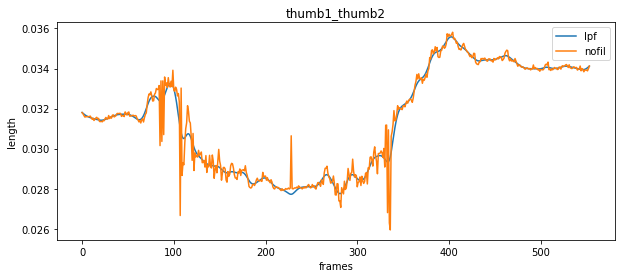

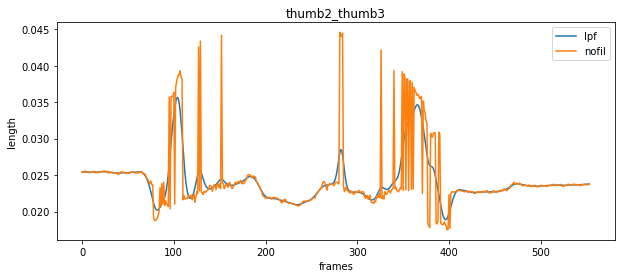

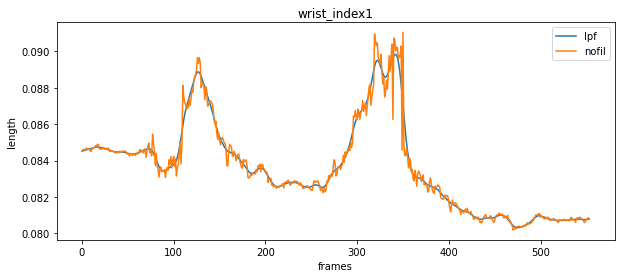

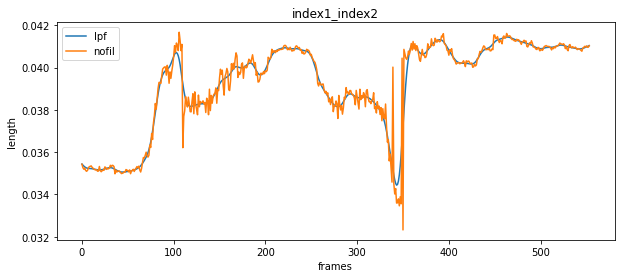

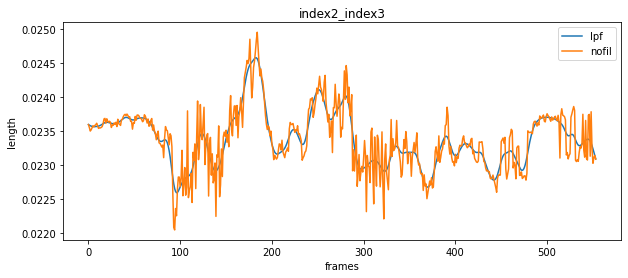

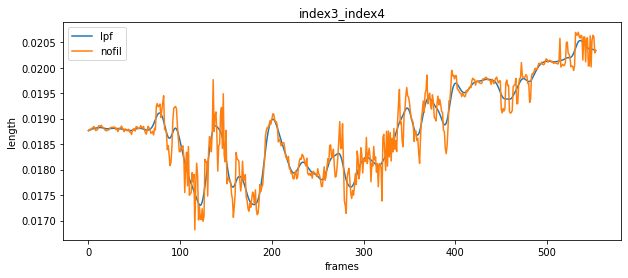

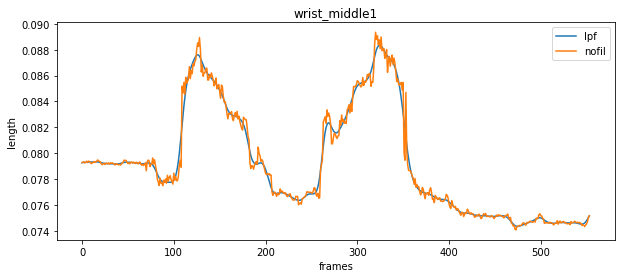

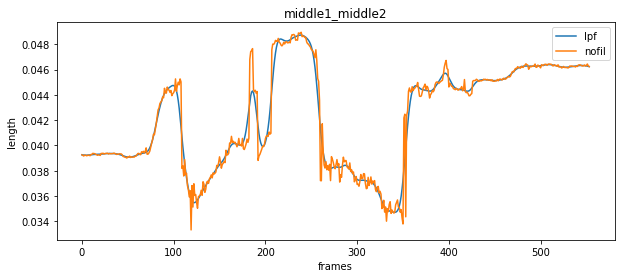

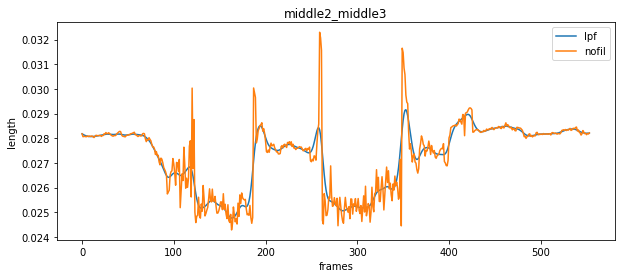

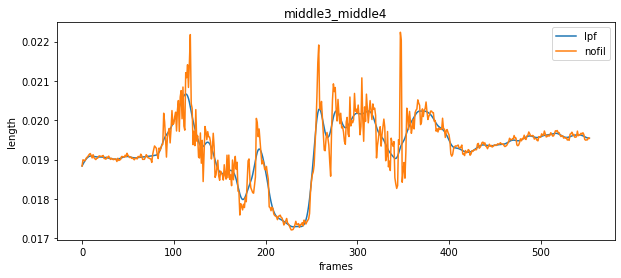

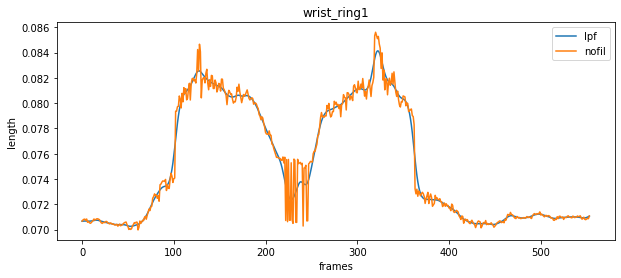

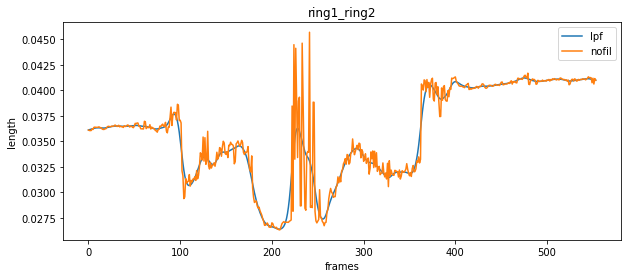

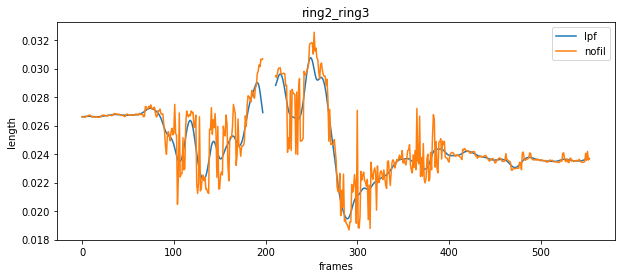

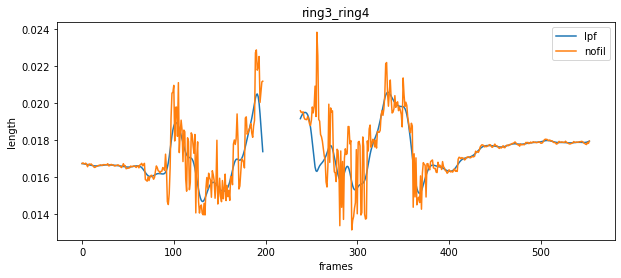

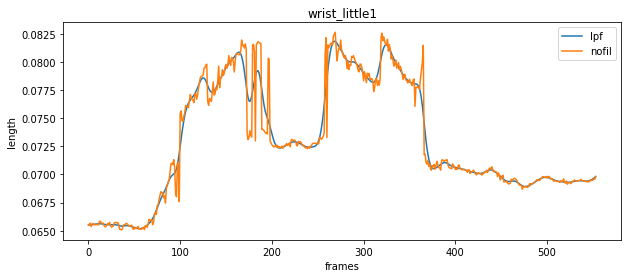

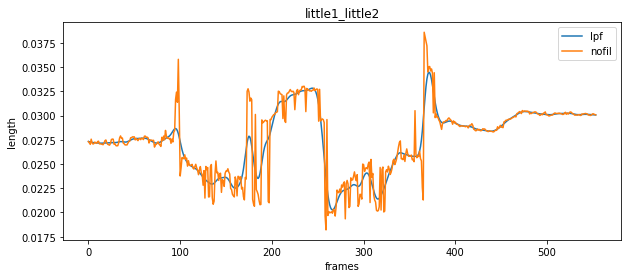

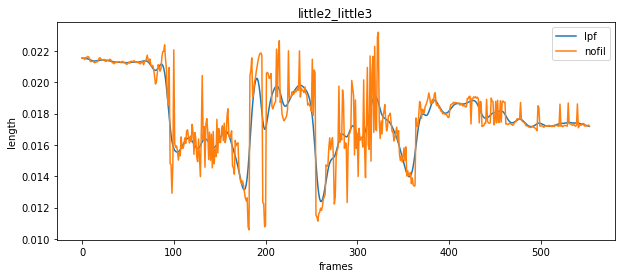

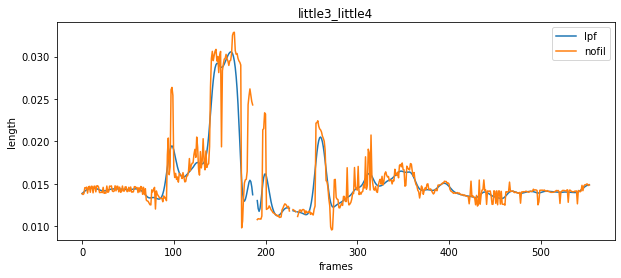

In [4]:
pairs = list(eucl_dst_kf.keys())
length_joints_lpf = list(eucl_dst_lpf.values())
# length_joints_kf = list(eucl_dst_kf.values())
length_joints_nofil = list(eucl_dst_nofil.values())
frames = [i for i in range(0, len(length_joints_lpf[0]))]

for i in range(0, len(pairs)):
    plt.figure(figsize=(10, 4))
    plt.plot(frames, length_joints_lpf[i], label='lpf')
#     plt.plot(frames, length_joints_kf[i], label='kf')
    plt.plot(frames, length_joints_nofil[i], label='nofil')
    plt.title(pairs[i])
    plt.xlabel("frames")
    plt.ylabel("length")
    plt.legend()
    plt.show()

In [5]:
# Fix the joints length under the constraints of the median
# Picking first frames from the length joints except for the elbow-wrist (200->250)
length_joints_lpf = list(eucl_dst_lpf.values())

elb_wri_dst = length_joints_lpf[0][200:250]
length_joints = [elb_wri_dst]

for joint in range(1, len(length_joints_lpf)):
    bodypart_first_dst = length_joints_lpf[joint][0:50]
    length_joints.append(bodypart_first_dst)

# Computing median
median_joints = []
for length_table in length_joints:
    median_joints.append(np.nanmedian(length_table))

In [14]:
def cost(params):
    split_coords = np.array_split(params, 2)
    new_bp1 = np.array_split(split_coords[0], len(split_coords[0]))
    new_bp2 = np.array_split(split_coords[1], len(split_coords[0]))
    frames = len(new_bp1) / 3
    new_length = np.zeros((int(frames),1))
    
    orig_bp1 = []
    orig_bp2 = []

    for i in range(int(frames)):
        new_length[i]=distance.euclidean(new_bp1[i], new_bp2[i])
    length_cost=np.sum(abs(new_length-orig_skel_length))
    
    new_dist = np.zeros((int(frames),1))
    for i in range(int(frames)):
        new_dist[i]=distance.euclidean(new_bp1[i], np.array(orig_wrist.iloc[i]))+distance.euclidean(new_bp2[i], np.array(orig_thumb.iloc[i]))
    dist_cost=np.sum(new_dist)

    c = (alpha * length_cost) + ((1-alpha) * dist_cost)
    
    return c

# Init params
alpha = 1

# Get data
orig_wrist = lpf_coord[lpf_coord['bodypart'] == 'wrist'][['x', 'y', 'z']]
orig_wrist.index=range(len(orig_wrist))
orig_thumb = lpf_coord[lpf_coord['bodypart'] == 'thumb1'][['x', 'y', 'z']]
orig_thumb.index=range(len(orig_thumb))
orig_skel_length = median_joints[1]

# Compute the optimisation and add new 3d coordinates to tables
x0=[orig_wrist,orig_thumb]

# BFGS method
method   ="BFGS"
tol      = 0.01
options  = {"maxiter":50, "disp":True}
new_coords=minimize(cost, x0, method=method, tol=tol, options=options)
new_coords = np.array_split(new_coords.x, 2)

KeyboardInterrupt: 

In [51]:
# Prepare the data for display
new_wrist = []
new_thumb = []
new_wrist.append(new_coords[0])
new_thumb.append(new_coords[1])

new_wrist = np.array_split(new_wrist[0], 554)
new_wrist_coords = np.vstack(new_wrist)

new_thumb = np.array_split(new_thumb[0], 554)
new_thumb_coords = np.vstack(new_thumb)

Text(0, 0.5, 'coordinates')

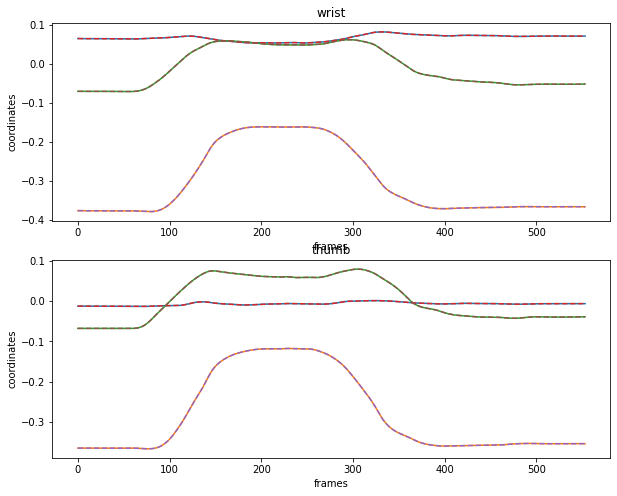

In [53]:
# Low Pass Filter coordinates - Optimisation coordinates
plt.figure(figsize=(10, 8))
plt.subplot(211)
plt.plot(orig_wrist)
plt.plot(new_wrist_coords,'--')
plt.title("wrist")
plt.xlabel("frames")
plt.ylabel("coordinates")
plt.subplot(212)
plt.plot(orig_thumb)
plt.plot(new_thumb_coords,'--')
plt.title("thumb")
plt.xlabel("frames")
plt.ylabel("coordinates")

In [54]:
# wrist and thumb 3d coordinates dataframe after optimisation
wrist_coord = pd.DataFrame(new_wrist_coords, columns = ['x', 'y', 'z'])
wrist_coord['frame'] = wrist_coord.index
thumb1_coord = pd.DataFrame(new_thumb_coords, columns = ['x', 'y', 'z'])
thumb1_coord['frame'] = thumb1_coord.index

Text(0.5, 1.0, 'x wrist before/after optim')

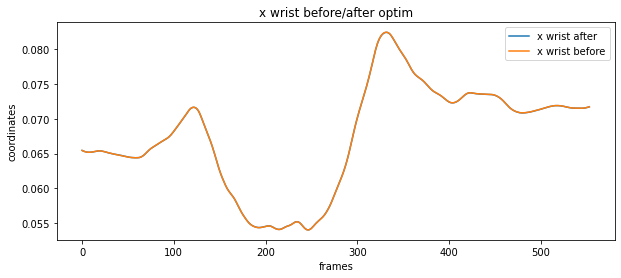

In [55]:
# Low Pass Filter X coordinates - Optimisation X coordinates
orig_wrist['frame'] = orig_wrist.index
orig_thumb['frame'] = orig_thumb.index

plt.figure(figsize=(10, 4))
plt.plot(wrist_coord['frame'], wrist_coord['x'], label="x wrist after")
plt.plot(orig_wrist['frame'], orig_wrist['x'], label="x wrist before")
plt.legend()
plt.xlabel("frames")
plt.ylabel("coordinates")
plt.title("x wrist before/after optim")

In [56]:
# Euclidean distance between wrist and thumb after optimisation
eucl_optim=[]

for frame in range (0, len(wrist_coord)):
    data1 = np.vstack(wrist_coord.iloc[frame])
    data2 = np.vstack(thumb1_coord.iloc[frame])
    if ~np.isnan(data1).any() and ~np.isnan(data2).any():
        eucl_optim.append(distance.euclidean(data1, data2))
    else:
        eucl_optim.append(np.float64('nan'))

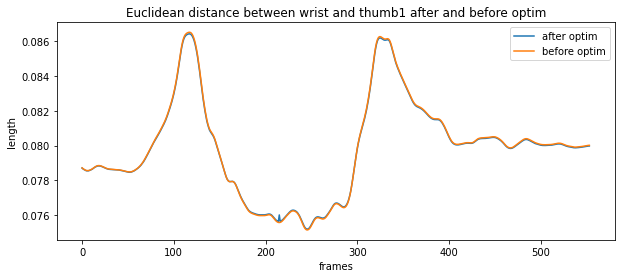

In [57]:
# Euclidean distance difference
plt.figure(figsize=(10, 4))
plt.plot(frames, eucl_optim, label="after optim")
plt.plot(frames, length_joints_lpf[1], label='before optim')
plt.legend()
plt.plot()
plt.xlabel("frames")
plt.ylabel("length")
plt.title("Euclidean distance between wrist and thumb1 after and before optim")
plt.show()